# Siren Exploration
SIREN (Sinusoidal Representation Networks) leverage periodic activation functions for implicit neural representations and demonstrate that these networks are ideally suited for representing complex natural signals and their derivatives. **bold text**

This is a colab copied from Siren MLP, proposed in [Implicit Neural Activations with Periodic Activation Functions](https://vsitzmann.github.io/siren).


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

Now, we code up the sine layer, which will be the basic building block of SIREN. This is a much more concise implementation than the one in the main code, as here, we aren't concerned with the baseline comparisons.

In [2]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

And finally, differential operators that allow us to leverage autograd to compute gradients, the laplacian, etc.

In [3]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

# Experiments


## Fitting an audio signal
<a id='section_2'></a>

Here, we'll use Siren to parameterize an audio signal - i.e., we seek to parameterize an audio waverform $f(t)$  at time points $t$ by a SIREN $\Phi$.

That is we seek the function $\Phi$ such that:  $\mathcal{L}\int_\Omega \lVert \Phi(t) - f(t) \rVert \mathrm{d}t$  is minimized, in which  $\Omega$  is the domain of the waveform.

For the audio, we'll use the bach sonata:

In [4]:
import scipy.io.wavfile as wavfile
import io
from IPython.display import Audio

if not os.path.exists('gt_bach.wav'):
    !wget https://vsitzmann.github.io/siren/img/audio/gt_bach.wav

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


--2023-12-24 14:45:13--  https://vsitzmann.github.io/siren/img/audio/gt_bach.wav
Resolving vsitzmann.github.io (vsitzmann.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to vsitzmann.github.io (vsitzmann.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.vincentsitzmann.com/siren/img/audio/gt_bach.wav [following]
--2023-12-24 14:45:13--  https://www.vincentsitzmann.com/siren/img/audio/gt_bach.wav
Resolving www.vincentsitzmann.com (www.vincentsitzmann.com)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to www.vincentsitzmann.com (www.vincentsitzmann.com)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1232886 (1.2M) [audio/wav]
Saving to: 'gt_bach.wav'

gt_bach.wav         100%[===================>]   1.17M  --.-KB/s    in 0.04s   

2023-12-24 14:45:13 (29.7 MB/s) - 'gt_bach.wav' saved [1232886/1232886]



Let's build a little dataset that computes coordinates for audio files:

In [5]:
class AudioFile(torch.utils.data.Dataset):
    def __init__(self, filename):
        self.rate, self.data = wavfile.read(filename)
        self.data = self.data.astype(np.float32)
        self.timepoints = get_mgrid(len(self.data), 1)

    def get_num_samples(self):
        return self.timepoints.shape[0]

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        amplitude = self.data
        scale = np.max(np.abs(amplitude))
        amplitude = (amplitude / scale)
        amplitude = torch.Tensor(amplitude).view(-1, 1)
        return self.timepoints, amplitude

Let's instantiate the Siren. As this audio signal has a much higer spatial frequency on the range of -1 to 1, we increase the $\omega_0$ in the first layer of siren.

In [6]:
bach_audio = AudioFile('gt_bach.wav')

dataloader = DataLoader(bach_audio, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)

# Note that we increase the frequency of the first layer to match the higher frequencies of the
# audio signal. Equivalently, we could also increase the range of the input coordinates.
audio_siren = Siren(in_features=1, out_features=1, hidden_features=256,
                    hidden_layers=3, first_omega_0=3000, outermost_linear=True)
audio_siren.cuda()

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=1, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

Let's have a quick listen to ground truth:

In [7]:
rate, _ = wavfile.read('gt_bach.wav')

model_input, ground_truth = next(iter(dataloader))
Audio(ground_truth.squeeze().numpy(),rate=rate)

We now fit the Siren to this signal.

Step 0, Total loss 0.032916


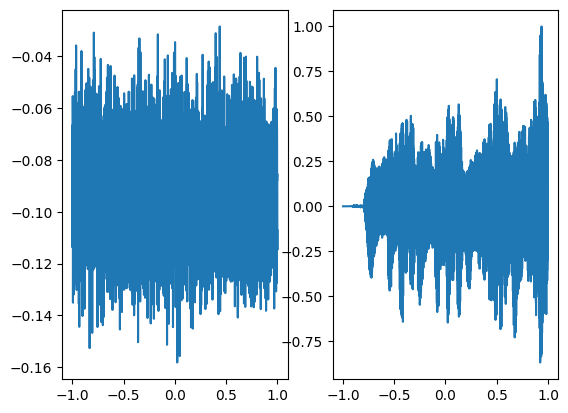

Step 100, Total loss 0.002865


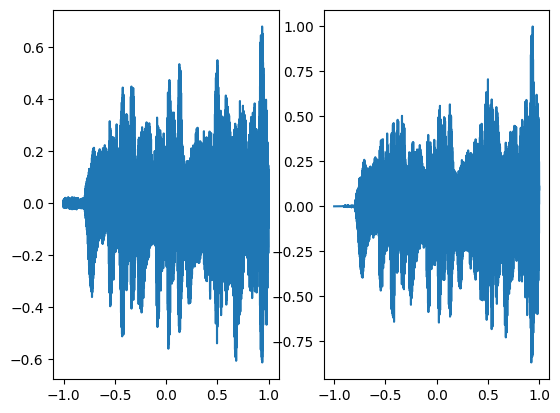

Step 200, Total loss 0.001306


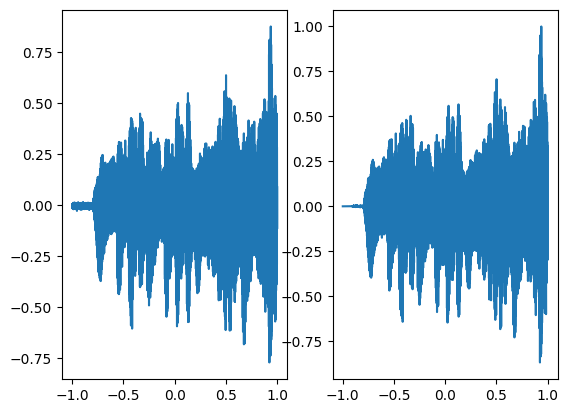

Step 300, Total loss 0.000787


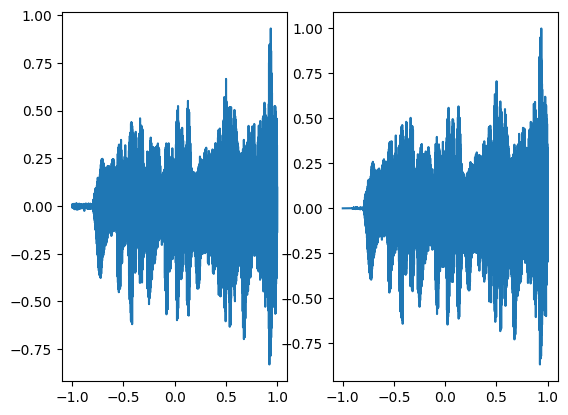

Step 400, Total loss 0.000647


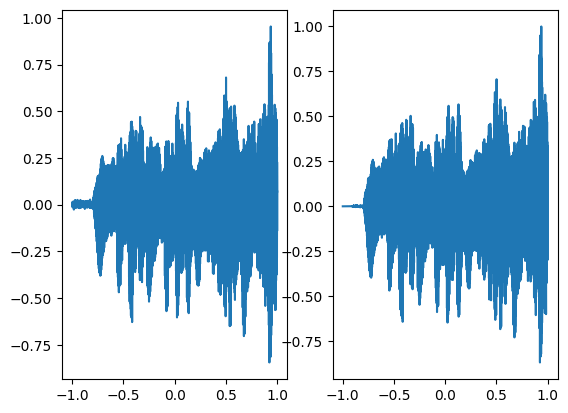

Step 500, Total loss 0.000476


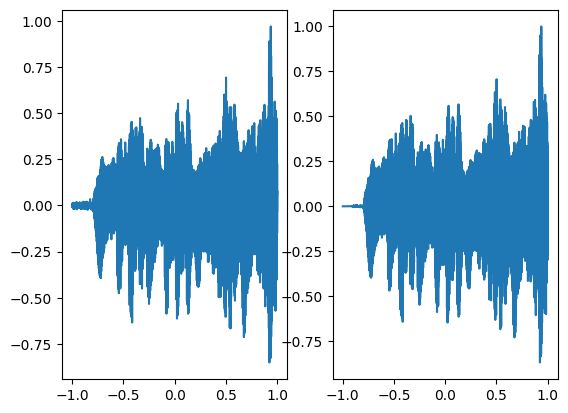

Step 600, Total loss 0.000452


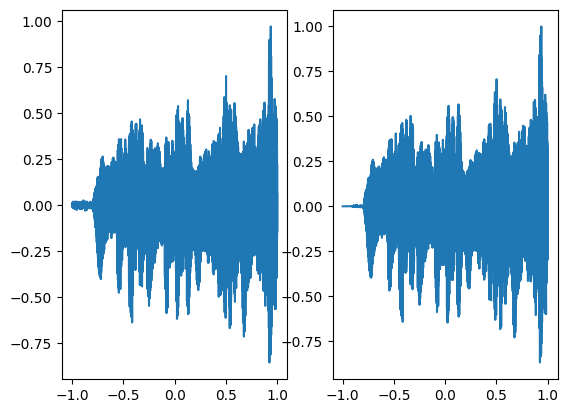

Step 700, Total loss 0.000209


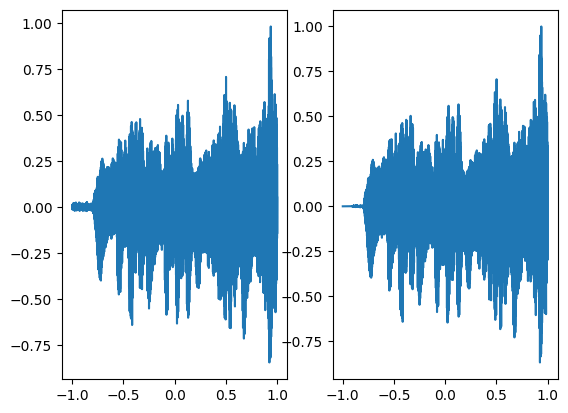

Step 800, Total loss 0.000177


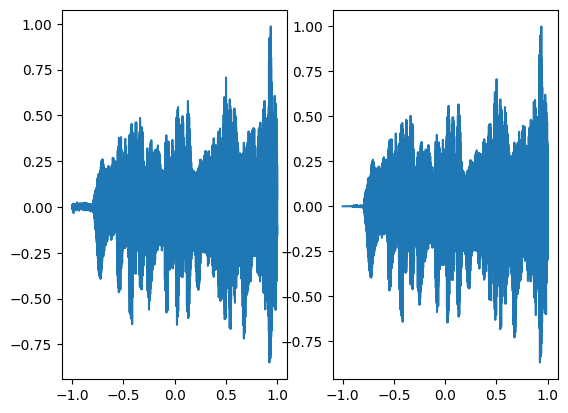

Step 900, Total loss 0.000248


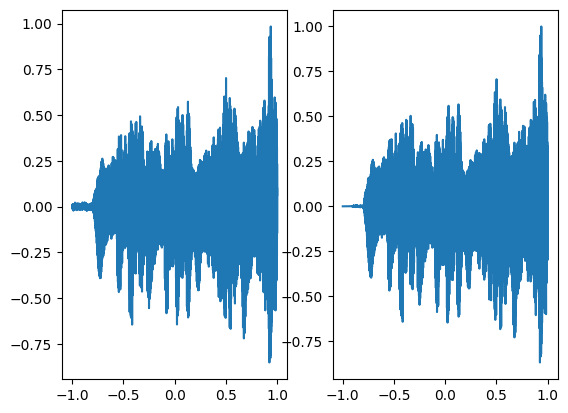

In [8]:
total_steps = 1000
steps_til_summary = 100

optim = torch.optim.Adam(lr=1e-4, params=audio_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output, coords = audio_siren(model_input)
    loss = F.mse_loss(model_output, ground_truth)

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))

        fig, axes = plt.subplots(1,2)
        axes[0].plot(coords.squeeze().detach().cpu().numpy(),model_output.squeeze().detach().cpu().numpy())
        axes[1].plot(coords.squeeze().detach().cpu().numpy(),ground_truth.squeeze().detach().cpu().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

In [9]:
final_model_output, coords = audio_siren(model_input)
Audio(final_model_output.cpu().detach().squeeze().numpy(),rate=rate)

As we can see, within few iterations, Siren has approximated the audio signal very well!